<a href="https://colab.research.google.com/github/moodychinsaki/MLprojectt/blob/main/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model2 Hyperparameter tuning

In [1]:
import os
from os import listdir, makedirs
from os.path import isfile, join
import pandas as pd
from PIL import Image
import glob
from pathlib import Path
import shutil
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.optimizers import SGD, RMSprop
import cv2
from os.path import isfile,join, exists
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import statistics as st
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Activation
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import gc





In [2]:
pip uninstall keras-preprocessing -y

Found existing installation: Keras-Preprocessing 1.1.2
Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2


In [3]:
pip install -q -U git+https://github.com/keras-team/keras-preprocessing.git

  Preparing metadata (setup.py) ... done


In [4]:
pip install -q -U keras-tuner

In [5]:
import keras_tuner as kt

## Get the data from cloud

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/CatsDogs.zip', 'r') # Open the zip file containing all the images
zip_ref.extractall('/tmp') # Extract the file in /tmp folder
zip_ref.close()

## Removing corrupted images

In [8]:
# Assignment of paths
cat_path = glob.glob("./../tmp/CatsDogs/Cats/*.jpg")
dog_path = glob.glob("./../tmp/CatsDogs/Dogs/*.jpg")
paths = list([cat_path, dog_path])

In [9]:
#  generic code for removing corrupted images
num_skipped = 0
total = 0
for path in paths:
  for filename in path:
    if os.path.exists(filename):
      try:
        total += 1
        with open(filename, "rb") as fobj:
          is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
      except IOError:
        pass
      if not is_jfif:
        num_skipped += 1
        # Deleting corrupted image
        os.remove(filename)
 



**Concatanete data frames **
not stratifying this time

In [10]:
df_cat = pd.DataFrame({"img_name": [f"/tmp/CatsDogs/Cats/{i}" for i in os.listdir('/tmp/CatsDogs/Cats')]})
df_cat["label"] = "cat"
df_dog = pd.DataFrame({"img_name": [f"/tmp/CatsDogs/Dogs/{i}" for i in os.listdir('/tmp/CatsDogs/Dogs')]})
df_dog["label"] = "dog"
ash_df = pd.concat([df_cat, df_dog], ignore_index=True)
ash_df = ash_df.sample(frac=1, random_state = 789).reset_index(drop=True) # shuffles and drops old index, shuffle is reproducable

In [11]:
# Splits as training set and test set
trainPlusval_df, test_df = train_test_split(ash_df, test_size=0.2, random_state = 789)
     

# Splits training set into training and validation set (15% validation)
train_df, val_df = train_test_split(trainPlusval_df, test_size=0.15, random_state = 789)

Data generators to prevent ram crashes on **Colab** free plan

In [12]:
image_size = (160,160,3) # increased to 160x160 for model2hypt

In [13]:
# Data Generators for normalising images
imag_gen = ImageDataGenerator(rescale=1/255) 

In [14]:
# flow_from_dataframe method of ImageDataGenerator creates data generators for training, validation, and testing
trainPlusvalid_gen = imag_gen.flow_from_dataframe(dataframe=trainPlusval_df, 
                                                            directory=None, x_col="img_name",
                                                            y_col="label",
                                                            batch_size=90, seed=789, #batch size 90 for model2hypt
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=image_size[0:2]) # img size decreased to 160x160

test_gen = imag_gen.flow_from_dataframe(dataframe = test_df, directory=None,
                                                          x_col="img_name", y_col="label",
                                                          batch_size=90, 
                                                          seed=789, shuffle=True, class_mode="binary",
                                                          target_size=image_size[0:2])

train_gen = imag_gen.flow_from_dataframe(dataframe=train_df, 
                                                            directory=None, x_col="img_name",
                                                            y_col="label",
                                                            batch_size=90, seed=789,
                                                            shuffle=True, class_mode="binary", 
                                                            target_size=image_size[0:2])

valid_gen = imag_gen.flow_from_dataframe(dataframe= val_df, 
                                                            directory=None, x_col="img_name",
                                                            y_col="label",
                                                            batch_size=90, seed=789,
                                                            shuffle=True, class_mode="binary", # 0 or 1 labels cats or dog
                                                            target_size=image_size[0:2])

Found 18728 validated image filenames belonging to 2 classes.
Found 4682 validated image filenames belonging to 2 classes.
Found 15918 validated image filenames belonging to 2 classes.
Found 2810 validated image filenames belonging to 2 classes.


Model 2 (Hyperparameter **tuning**) 

In [15]:
model2 = Sequential(name="MODEL_2hypt")

# add padding to the first Conv2D layer
model2.add(Conv2D(16, (3, 3), strides=(2, 2) ,input_shape=image_size, padding='valid'))  
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2))) 

model2.add(Conv2D(128, (3, 3), strides=(2, 2), padding='valid' ))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
# added hidden layer model2hypt
model2.add(Conv2D(256, (3, 3), strides=(2, 2), padding='valid'))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))


model2.add(Flatten())  
model2.add(Dense(32))

model2.add(Dense(1))
model2.add(Activation('sigmoid'))

In [16]:
model2.summary()

Model: "MODEL_2hypt"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 79, 79, 16)        448       
                                                                 
 activation (Activation)     (None, 79, 79, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 39, 39, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 19, 128)       18560     
                                                                 
 activation_1 (Activation)   (None, 19, 19, 128)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 9, 128)        0         
 2D)                                                   

In [17]:
# Compile
#model2 = model_2_specification()
model2.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
tensorboard = keras.callbacks.TensorBoard(log_dir="./results",)

In [18]:
# Fit, plot and validate the model
step_size_train = trainPlusvalid_gen.n//trainPlusvalid_gen.batch_size
step_size_validation = test_gen.n//test_gen.batch_size

fit2 = model2.fit_generator(generator= trainPlusvalid_gen,
                    steps_per_epoch=step_size_train,
                    validation_data=test_gen,
                    validation_steps=step_size_validation,
                    epochs=20, # 20 epochs for model2hypt
                    callbacks=[tensorboard])

<ipython-input-18-c2c3d933b424>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fit2 = model2.fit_generator(generator= trainPlusvalid_gen,


Epoch 1/20
208/208 [==============================] - 93s 396ms/step - loss: 0.6427 - accuracy: 0.6168 - val_loss: 0.5761 - val_accuracy: 0.6953
Epoch 2/20
208/208 [==============================] - 82s 393ms/step - loss: 0.5171 - accuracy: 0.7425 - val_loss: 0.5056 - val_accuracy: 0.7573
Epoch 3/20
208/208 [==============================] - 75s 363ms/step - loss: 0.4374 - accuracy: 0.8019 - val_loss: 0.4643 - val_accuracy: 0.7880
Epoch 4/20
208/208 [==============================] - 78s 373ms/step - loss: 0.3808 - accuracy: 0.8305 - val_loss: 0.4509 - val_accuracy: 0.8058
Epoch 5/20
208/208 [==============================] - 77s 372ms/step - loss: 0.3224 - accuracy: 0.8607 - val_loss: 0.4192 - val_accuracy: 0.8173
Epoch 6/20
208/208 [==============================] - 81s 391ms/step - loss: 0.2710 - accuracy: 0.8838 - val_loss: 0.4375 - val_accuracy: 0.8190
Epoch 7/20
208/208 [==============================] - 83s 397ms/step - loss: 0.2097 - accuracy: 0.9132 - val_loss: 0.4699 - val_ac

In [21]:
test_loss, test_acc = model2.evaluate(test_gen)
print("Test Loss: "+str(test_loss))
print("Test Accuracy: "+str(test_acc))

53/53 [==============================] - 16s 298ms/step - loss: 1.1829 - accuracy: 0.8174
Test Loss: 1.182927131652832
Test Accuracy: 0.817385733127594


In [22]:
def plot_loss_curves(fit2):
    
   
    train_loss=fit2.history['loss']
    val_loss=fit2.history['val_loss']

    train_accuracy=fit2.history['accuracy']
    val_accuracy=fit2.history['val_accuracy']

    epochs=range(1,len(fit2.history['loss'])+1)        # 0 , ... + 5 olarak degisebilir epochs 50 civari olsa
    plt.figure(figsize=(20,7))

     # plot accuracy data
    plt.subplot(1,2,2)
    plt.plot(epochs,train_accuracy,label="training_acc", color='red')
    plt.plot(epochs,val_accuracy,label="validation_acc", color='green')
    plt.title("MODEL_2 Accuracy curves")
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.legend()

  # plot loss data
    plt.subplot(1,2,1)
    plt.plot(epochs,train_loss,label="training_loss", color='red' )
    plt.plot(epochs,val_loss,label="validation_loss", color='green')
    plt.title("MODEL_2 Loss curves")
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend()

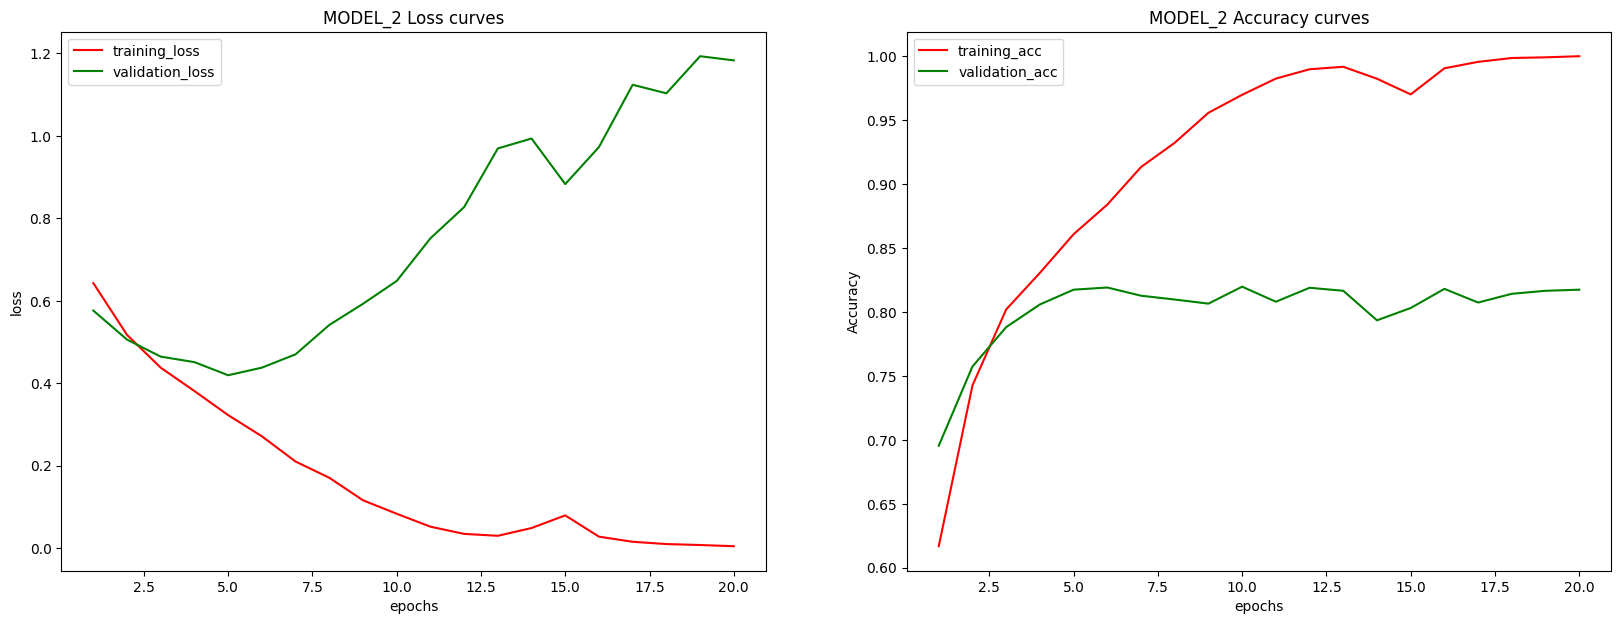

In [23]:
plot_loss_curves(fit2)